Only sample $\mu$ and group.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import numpy.random as npr
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 5.5, 3.5

# Create Data Set

\begin{align}
\mu_k &\sim \mathcal{N} (\mu_{\rm P}, \sigma^2_{\rm P}), \ \ k = 1, \cdots, K \\
\boldsymbol{\theta} &\sim {\rm Dir}(\boldsymbol{\alpha}), \  \ \ \boldsymbol{\alpha} = (\alpha_1, \cdots, \alpha_K) \\
z_i &\sim {\rm Multi}(1 | \boldsymbol{\theta}), \ \ i = 1, \cdots, D \\
x_i &\sim \mathcal{N} (u_{z_i = k}, \sigma^2), \ \ i = 1, \cdots, D
\end{align}

In [4]:
# Set Parameters
K_true = 4 ; D = 500 ; K = K_true
uP_true = 0 ; sigmaP_true = 5 ; uP = 1 ; sigmaP = 5
sigma = 2.2
alpha_true = np.full(K_true, 1.0) ; alpha = alpha_true.copy()

In [5]:
mu_true = npr.normal(uP_true, sigmaP_true, K_true)
mu_true = np.array([0.09374993, 5.82269546, 12, 19.83029225])
theta_true = npr.dirichlet(alpha_true)
theta_true = np.array([ 1.5, 1.8, 1.2, 1.1]) ; theta_true = theta_true/theta_true.sum()
Z_true = npr.choice(K_true, D, p = theta_true)
X = np.array(list(map(lambda i: npr.normal(mu_true[i], sigma), Z_true)))

In [6]:
mu_true

array([  0.09374993,   5.82269546,  12.        ,  19.83029225])

In [7]:
theta_true

array([ 0.26785714,  0.32142857,  0.21428571,  0.19642857])

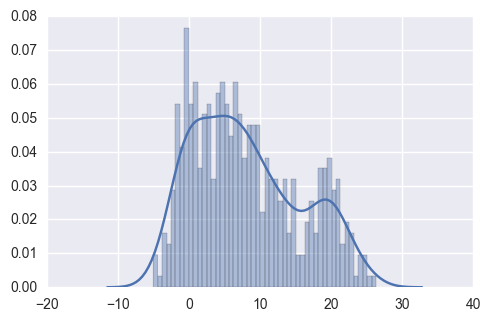

In [8]:
#sns.distplot(X, hist=True, kde=True, bins=int((X.max()-X.min())/2))
sns.distplot(X, hist=True, kde=True, bins=50)

# Collapsed Gibbs Sampling

In [9]:
np.seterr(all='raise')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [10]:
def choose_z(prob, method, *z_previous):
    if method == "multi":
        return npr.choice(K, p=prob)
    
    elif method == "slicefailed":
        # サンプルを作りたいthetaが毎回の更新で変わってしまうから、下のように毎回正しいthetaからsliceしないとダメなのでは
        u = npr.uniform(0, prob[z_previous])
        #slicesample_count.append(len(np.where(prob > u)[0]))
        
        return np.random.choice(np.where(prob > u)[0]) # draw uniformly from categories that are above u
    
    elif method == "slice":
        num_sampling = 300
        chain = np.zeros((num_sampling, 1, 1))
        chain[0][0][0] = int(npr.multinomial(1, np.repeat(1/K, K)).nonzero()[0]) # initial group index
       
        for i in range(0, num_sampling-1):
            u = npr.uniform(0, prob[int(chain[i][0][0])])

            chain[i+1][0][0] = np.random.choice(np.where(prob > u)[0])
            
        prob_sliced = np.array(list(map(lambda k: np.sum(chain[:, 0, 0]==k), range(K)))) # count number of each category
        prob_sliced = prob_sliced / prob_sliced.sum()
        
        return npr.choice(K, p=prob_sliced)
    
    elif method == "retrospective":
        num_sampling = 300
        chain = np.zeros((num_sampling, 1, 1))
        chain[0][0][0] = int(npr.multinomial(1, np.repeat(1/K, K)).nonzero()[0]) # initial group index        
        
        rho = npr.uniform(0, max(prob))
        for i in range(0, num_sampling-1):
            while True:
                k = npr.choice(K)
                if prob[k] >= rho:
                    chain[i+1][0][0] = k
                    break
                    
        prob_retro = np.array(list(map(lambda k: np.sum(chain[:, 0, 0]==k), range(K))))
        prob_retro = prob_retro / prob_retro.sum()
        return npr.choice(K, p=prob_retro)

In [11]:
def sampling(method, num_iteration):
    # Parameters Settings
    K = K_true
    Z = npr.choice(K, D, p = np.full(K, 1/K))
    theta = npr.dirichlet(alpha_true)
    mu = npr.normal(uP_true, sigmaP_true, K)
    
    for iteration in range(num_iteration):
        Zcount_array = np.array(list(map(lambda k: np.sum(Z==k), range(K)))) # zeroがあっても大丈夫

        z_prev = 0
        for d in npr.permutation(np.arange(D)):
            ### Sampling Zi ###
            Zcount_array[ Z[d] ] -= 1
            theta_temp_array = np.zeros(K)
            x_temp = X[d].copy()
            X[d] = 0

            for k in range(K):
                # Normal (1st term)
                current_mu_k = X[ Z == k ].sum() / (len(X) - 1)
                mean1 = x_temp - current_mu_k
                sd1 = sigma

                logterm1 = (-1/2)*np.power(sd1, 2)  - ( ( np.power((mean1), 2) )  / ( 2 * np.power(sd1, 2)  ) )

                # Multii (2nd term)
                term2 = ( Zcount_array[k] + alpha[k]   ) / ( Zcount_array + alpha ).sum()

                theta_temp_array[k] = logterm1 + np.log(term2)

            theta_temp_array = np.exp( theta_temp_array - sp.misc.logsumexp(theta_temp_array) )
            new_zi = choose_z(theta_temp_array, method, z_prev)
            Z[d] = new_zi
            X[d] = x_temp.copy()
            Zcount_array[ Z[d] ] += 1
            z_prev = new_zi
            
    return Z

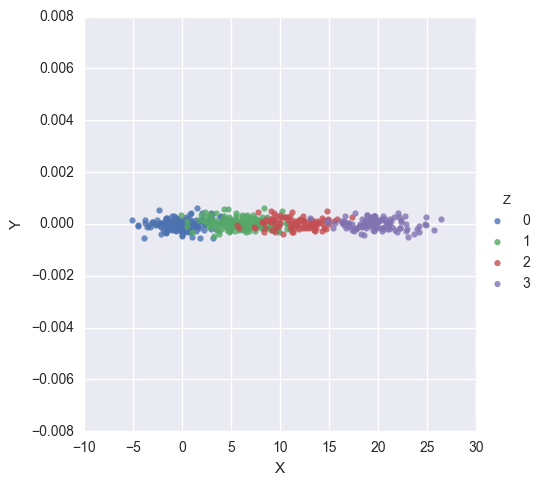

In [12]:
# True
data = pd.DataFrame({'X':list(X), 'Z':[str(i) for i in Z_true], 'Y':[npr.normal(0,0.0002) for i in Z_true]})
data['Z'] = data['Z'].astype('category')
sns.lmplot('X', 'Y', data=data, hue='Z', fit_reg=False)

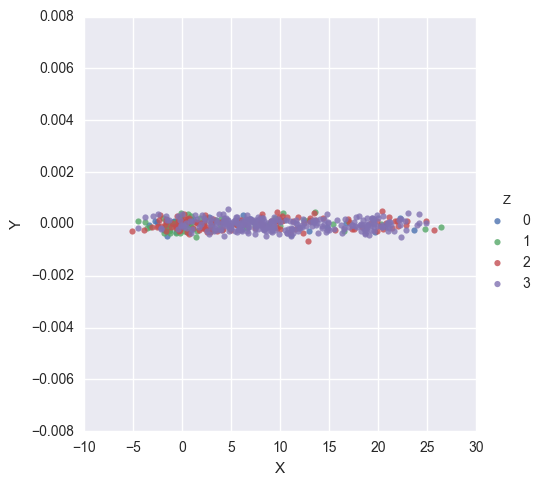

In [13]:
#slicesample_count = []

Z = sampling("slicefailed", 1000)
results = pd.DataFrame({'X':list(X), 'Z':[str(i) for i in Z], 'Y':[npr.normal(0,0.0002) for i in Z]})
results['Z'] = results['Z'].astype('category')
sns.lmplot('X', 'Y', data=results, hue='Z', fit_reg=False)

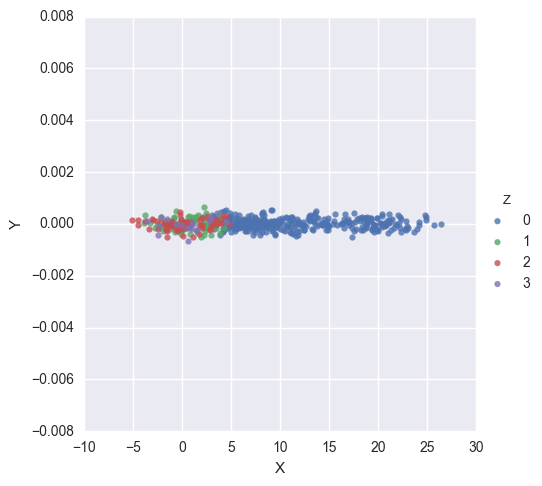

In [14]:
Z = sampling("multi", 100)
results = pd.DataFrame({'X':list(X), 'Z':[str(i) for i in Z], 'Y':[npr.normal(0,0.0002) for i in Z]})
results['Z'] = results['Z'].astype('category')
sns.lmplot('X', 'Y', data=results, hue='Z', fit_reg=False)

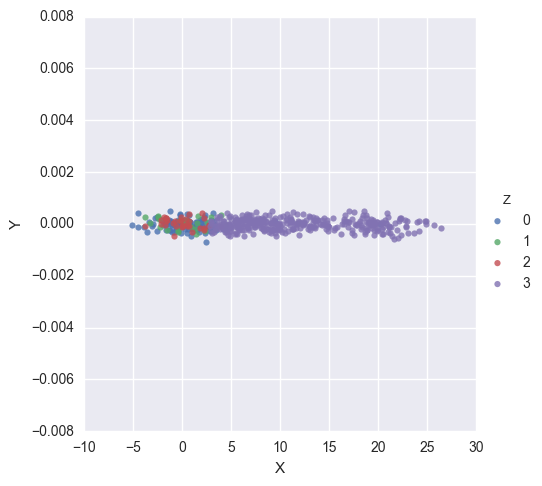

In [15]:
Z = sampling("slice", 20)
results = pd.DataFrame({'X':list(X), 'Z':[str(i) for i in Z], 'Y':[npr.normal(0,0.0002) for i in Z]})
results['Z'] = results['Z'].astype('category')
sns.lmplot('X', 'Y', data=results, hue='Z', fit_reg=False)

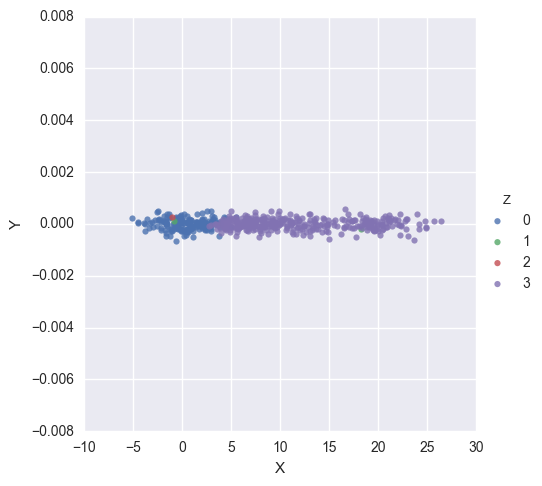

In [16]:
Z = sampling("retrospective", 20)
results = pd.DataFrame({'X':list(X), 'Z':[str(i) for i in Z], 'Y':[npr.normal(0,0.0002) for i in Z]})
results['Z'] = results['Z'].astype('category')
sns.lmplot('X', 'Y', data=results, hue='Z', fit_reg=False)